In [1]:
cm = 1/2.54
def getparentdir(foldername):
    import os
    parent = "E:\Raphael\Data"
    listdir = os.listdir(parent)
    for d in listdir:
        if d[0] == foldername:
            parent = os.path.join(parent, d)
    return parent

def loadgroup(path):
    # This function loads any csv dedicated to tell ing the algorithm what fields correspond to what condition
    #Input: Path to a specific file that contains a map of the experiment
    #0 = no experiment was performed in this slot -> will be deleted later
    #None -> Condition not relevent for experiment (e.g. a well or lane that has only one condition while others have two)
    # Output: dictionary with A1-H12 as keys containing the labels
    import pandas as pd
    import csv
    import string
    ABC = list(string.ascii_uppercase)
    dic = {}
    with open(path) as csvfile:
        reader = csv.reader(csvfile, delimiter = ";")
        i = 0
        #loop through all wells
        for row in reader:
            for j in range(len(row)):
                #find correct enumeration
                key = ABC[i]+str(j+1) 
                #delete unwanted letters in first position
                f = row[j].split("ï»¿") 
                f = f[len(f)-1]
                dic[key] = f
            i = i+1
    return(dic)

def subtractbasic(dic, header):
    #subtracts the background flourescence measured from untransfected cells from the others
    #Input: Labeled dictionary cotaining the measured intensity by flourometry
    #Output: Addition of "Subtracted" entries. These will be used afterwards
    #Output dict also differs from input dict!!!!
    #Input has Wells as keys
    #Ouput will use fields (like "Wells", "Mean")
    import pandas as pd
    data = {}
    #loop though whole dict and create new one
    #new dict is organised by groups
    for key in dic:
        td = dic[key]
        for k in td:
            if k not in data:
                data[k] = []
            data[k].append(td[k])
        if "Well" not in data:
            data["Well"] = []
        data["Well"].append(key)
        if "Lane" not in data:
            data["Lane"] = []
        data["Lane"].append(key[0])
        if "Col" not in data:
            data["Col"] = []
        data["Col"].append(key[1:len(key)])
    #create dataframe to calculate median and subtract
    df = pd.DataFrame.from_dict(data)
    base = df[header][df["Group1"] == "NT"].median()
    head = df.keys()
    for i in range(len(base)):
        
        df[head[i]+"_sub"] =  pd.to_numeric(df[head[i]])-float(base[i])
    dic = df.to_dict()
    return dic

def clearf(dic):
    #clears dict of all unwanted entries
    delete = ["NT", "BL", "0"]
    import pandas as pd
    df = pd.DataFrame.from_dict(dic)
    
    for d in delete:
        df.drop(df.loc[df["Group1"]==d].index,inplace=True)
    dic = df.to_dict()
    return dic
    
    
def loadspark(loc):
    #loads the excel file generated by flourometry measurement
    #Input: Unedited xlsx file called "Spark"
    #Output: Labeled dictionary; without bradford information
    import pathophys as pp
    import pandas as pd
    import csv
    import os
    Sxlsx = os.path.join(loc,"Spark.xlsx")
    Scsv = os.path.join(loc,"Spark.csv")
    dic = {}
    read_file = pd.read_excel (Sxlsx)
    read_file.to_csv (Scsv, index = None, header=True)
    #xlsx file is easy to open with pandas
    #first is converted to csv then opened as such
    with open(Scsv) as csvfile:
            ind = 0
            header = []
            Wells = []
            reader = csv.reader(csvfile)
            for row in reader:
                #when the correct line is reached the information is gathered
                #This is done up to the 7th line
                if ind in range(1,8):
                    #The first entry denotes the kind of information written in the line
                    M = row[0]
                    #These are stored in the "Header" list
                    header.append(M)
                    #the fc variable tracks the index of the field in the row
                    fc = 0
                    for field in row:
                        #if the reader moves past the first entry the entries get converted to floats
                        if fc > 0 and ind > 1:
                            dic[Wells[fc]][M] = float(field)
                        else:
                            dic[Wells[fc]][M] = field
                        fc = fc+1
                    ind = ind+1
                #first row of results is denoted by "Wells"
                #when the reader reaches this line...
               
                if row[0] == "Well": 
                    #1. a list of all wells is created
                    Wells = row
                    #2. for each well a dictionary is created inside the main dict
                    for field in Wells:
                        dic[field] = {}
                    #the indicator is set to 1 to signal that n+the next line contains information
                    ind = 1
            #the entry "Well" is not needed (it only stores reduntant information)
            dic.pop("Well")
    #next the overlay is loaded to give meaning to the wells
    #files must me csv and named Groupx x being the number of the group (starting form 1)
    for filename in os.listdir(loc):
        if "Group" in filename:
            path = os.path.join(loc,filename)
            #The group name will be the column header of the labels
            group = filename.split(".")[0]
            #group gets loaded
            g = pp.loadgroup(path)
            #information is put into the original dict
            #since both are orgnaised by wells this is used to combine them
            for key in dic:
                dic[key][group] = g[key]
    #next the mean of the "NT" condition is subtracted from all wells
    dic = pp.subtractbasic(dic, header)
    #all wells not containing important information are cleared
    dic = pp.clearf(dic)
    return dic, header


def loadbff(loc):
    #loads the excel file generated by photometry measurement
    #Input: Unedited xlsx file called "Bradford"
    #Output: Labeled dictionary with bradford information
    import pathophys as pp
    import pandas as pd
    import csv
    import os
    #similar method as described above
    Bxlsx = os.path.join(loc,"Bradford.xlsx")
    Bcsv = os.path.join(loc,"Bradford.csv")
    dic = {}
    read_file = pd.read_excel (Bxlsx)
    read_file.to_csv (Bcsv, index = None, header=True)
    with open(Bcsv) as csvfile:
            ind = 0
            reader = csv.reader(csvfile)
            for row in reader:
                #There are more rows to  read
                if ind in range(1,9):
                    L = row[0]
                    for i in range(1,len(row)):
                        #w is the well ID
                        w = L+str(i)
                        dic[w] = row[i]
                    ind = ind+1
                #Indicator in this cas could be either "Abs" or "Signal" depending on which export was used
                if row[0] == "Abs" or row[0] == "Signal":
                    ind = 1
    d = {}
    #next the information is labeled
    #new dict will be  organised by these labels to ease merging later
    for filename in os.listdir(loc):
        if "BradLab.csv" in filename:
            path = os.path.join(loc,filename)
            bl = pp.loadgroup(path)
            for key in bl:
                if "BL" in bl[key]:
                    continue
                elif dic[key] == "":
                    continue
                else:
                    d[bl[key]] = dic[key]
            #all entries containing "0" therefore being unused are deleted
            if "0" in d.keys():
                d.pop("0")
    for key in d:
        d[key] = float(d[key])
    return d

def joinflourometry(dic, bf, header):
    #joins the two loaded dicts (spark and Bradford)
    import pandas as pd
    d = dic
    d["Bradford"]={}
    #loops through all wells in the spark file and collects the corresponding value from the bradford dict
    #info is stored in the bradford entry in the spark dict
    for wk in dic["Well"]:
        d["Bradford"][wk] = bf[dic["Well"][wk]]
    df = pd.DataFrame.from_dict(d)
    #realtive intensity is calculated
    for h in header:
        df[h+"_rel"] = df[h+"_sub"]/df["Bradford"]
    return df

def normalize(d, header):
    import pandas as pd
    pd.options.mode.chained_assignment = None
    #normalisation is used to compare results from different measuremets
    #all values are divided by mean of control variable
    # usually this means "X" ond/or "DMSO"
    if "Group2" in d:
        dfs1 = []
        for g1 in d["Group2"].unique():

            df1 = d[d["Group2"]==g1]
            for h in header:
                median = df1[h+"_rel"][df1["Group1"]=="X"].mean()
                df1[h+"_norm_X"] = df1[h+"_rel"]/median
            dfs1.append(df1)
        d = pd.concat(dfs1)
        dfs2 = []
        for g2 in d["Group1"].unique():
            print(g1)
            df1 = d[d["Group1"]==g2]
            for h in header:
                median = df1[h+"_rel"][df1["Group2"]=="DMSO"].mean()
                print(median)
                df1[h+"_norm_DMSO"] = df1[h+"_rel"]/median
            dfs2.append(df1)
        d = pd.concat(dfs2)
    else:
        for h in header:
            median = d[h+"_rel"][d["Group1"]=="X"].mean()
            d[h+"_norm"] = d[h+"_rel"]/median
    
    return(d)

def addtry(d, loc):
    #this function adds a "try" variable to each entry
    #value is defined by foldercontainig the information(either 1, 2,....)
    #Folders need to be labeled i numbers in an ascending manner
    import os
    t = os.path.split(loc)
    d["Try"] = t[1]
    return d

def create_df_flourometry(loc):
    #main function for creating a df for flourometry for a single try
    import pathophys as pp
    import pandas as pd
    #loads spark file
    dic, header = pp.loadspark(loc)
    #loads bradfors information
    bf = pp.loadbff(loc)
    #joins them
    d = pp.joinflourometry(dic, bf, header)
    #Includes Bradford in normalisation
    header.append("Bradford")
    d["Bradford_rel"] = d["Bradford"]
    #Normalizes entries
    nd = []

    dd = pp.normalize(d, header)
    nd.append(dd)
    d = pd.concat(nd)
    #Adds try
    d = pp.addtry(d, loc)
    return d

def getdir(directory):
    #searches for directories in main directory
    #Dirs containing results have to be named after a single number up to 10
    import os
    locs = []
    for i in range(1, 10):
        loc = os.path.join(directory, str(i))
        if os.path.isdir(loc):
            print(loc)
            locs.append(loc)
    return locs

def get_df_flourometry(specdir, boo):
    #main function for returning a single df for all tries of the flourometry experiment
    import pathophys as pp
    import pandas as pd
    import os
    parentdir = pp.getparentdir(specdir)
    directory = os.path.join(parentdir, "Flourometry")
    #locs is a list of all tries
    locs = pp.getdir(directory)
    dfs = []
    for loc in locs:
        #df from a single try gets created and appended to a list of dataframes
        df = pp.create_df_flourometry(loc)
        dfs.append(df)
    #dataframes are combined and their indexes reset
    df = pd.concat(dfs)
    df = df.reset_index(drop=True)
    #results are saved as csv
    resultsloc1 = os.path.join(parentdir, "Flourometry")
    resultsloc = os.path.join(resultsloc1, "Results.csv")
    df.to_csv(resultsloc)
    if boo != True:
        df = df[df["Try"]==boo]
    #print(df.to_string())
    display(df)
    return df
    

def load_dens(loc):
    import os
    import pandas as pd
    densloc = os.path.join(loc, "Densitometry")
    files = os.listdir(densloc)
    targets = []
    dfs = []
    for file in files:
        path = os.path.join(densloc, file)
        target = file.split("_")[0]
        targets.append(target)
        df = pd.read_csv(path)
        d = pd.DataFrame()
        d["Lane"] = df[" "]
        d[target] = df["Area"]
        dfs.append(d)
        
    d = dfs[0]
    #print(d)
    dcs = []
    for i in range(1, len(dfs)):
        d = d.join(dfs[i], rsuffix = str(i))
        dc = "Lane"+str(i)
        dcs.append(dc)
    df = d.drop(columns=dcs)
    return df, targets

def translatewb(l):
    import string
    import pandas as pd
    data = {"Lane": [], "Group1": [], "Group2": [] ,"Group3": []}
    for key in l:
        ABC = list(string.ascii_uppercase)
        ind = ABC.index(key[0])+1
        if ind not in data["Lane"]:
            data["Lane"].append(ind)
        data["Group"+key[1]].append(l[key])
    d = {}
    for key in data:
        if len(data[key]) != 0:
            d[key] = data[key]
    df = pd.DataFrame(data = d)
    return df

def create_df_wb(loc):
    import pathophys as pp
    import os
    import pandas as pd
    df, targets = pp.load_dens(loc)
    l = pp.loadgroup(os.path.join(loc, "Lanes.csv"))
    l = pp.translatewb(l)
    d = pd.merge(df, l)
    if "b-Actin" in d:
        for t in targets:
            d[t+"_rel"] = d[t]/d["b-Actin"]
        d["b-Actin_rel"] = d["b-Actin"]
    elif "Ponceau" in d:
        for t in targets:
            d[t+"_rel"] = d[t]/d["Ponceau"]
        d["Ponceau_rel"] = d["Ponceau"]
    d = pp.normalize(d, targets)
    d = pp.addtry(d, loc)
    return d

def get_df_wb(specdir, boo):
    import pathophys as pp
    import pandas as pd
    import os
    parentdir = pp.getparentdir(specdir)
    directory = os.path.join(parentdir, "WB")
    locs = pp.getdir(directory)
    dfs = []
    for loc in locs:
        df = pp.create_df_wb(loc)
        dfs.append(df)
    df = pd.concat(dfs)
    df = df.reset_index(drop=True)
    resultsloc1 = os.path.join(parentdir, "WB")
    resultsloc = os.path.join(resultsloc1, "Results.csv")
    df.to_csv(resultsloc)
    if boo != True:
        df = df[df["Try"]==boo]
    display(df)
    return df

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def calculatepvalues(df, x, y, ctrl, treatment):
    import pathophys as pp
    from scipy.stats import kstest, mannwhitneyu, ttest_ind
    kres = kstest(df[y], 'norm')
    pv = 0
    if kres[1] > 0.05:
        pv = ttest_ind(df[y][df[x] == ctrl], df[y][df[x] == treatment], alternative="two-sided")
        print("T-Test")
    else:
        pv = mannwhitneyu(df[y][df[x] == ctrl], df[y][df[x] == treatment], alternative="two-sided")
        print("MWY")
    p = pv[1]
    print(ctrl+" vs. "+treatment+": "+str(p))
    pa = pp.convert_pvalue_to_asterisks(p)
    return pa
    
def drawsigbars(df, ax, x, y, ctrl, treatment, maxv, y_range, diff):
    import matplotlib.pyplot as plt
    import pathophys as pp
    maxv = maxv+(y_range*0.15)
    ax.plot(
        [ctrl, ctrl, treatment, treatment],
        [maxv, maxv, maxv, maxv], lw=1, c='k'
    )
    p = pp.calculatepvalues(df, x, y, ctrl, treatment)    
    ax.text((diff), maxv, p, ha='center', va='bottom', fontsize=11)
    
    
def barplot3(ax, df, x, y, z, bw, ls, sigp):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import math as mat
    import matplotlib as mpl
    import pathophys as pp
    import pandas as pd

    maxvs = []
    cond = []
    #plt.scatter(df["Group1"],df["Mean_norm"])
    ns = len(df["Try"].unique())
    print("n = "+str(ns))

    for g in df[x].unique():
        
        cond.append(g)
        data = pd.to_numeric(df[y][df[x]==g])
        sd = data.std()
        if mat.isnan(sd) == True:
            sd = 0
        ci = 1.96*sd/mat.sqrt(len(data))
        label = g
        if g == "X":
            label = "Ctrl"
        ax.bar(g, data.mean(), bw, yerr=ci, capsize=4, linewidth=ls, edgecolor="black")
        maxvs.append(data.mean()+ci)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(ls)
        if axis in ['top','right']:
            ax.spines[axis].set_visible(False)
    ax.tick_params(width=ls)
    maxv = max(maxvs)
    hightind = 0
    bottom, top = ax.get_ylim()
    y_range = top - bottom
    treatmenti = 0
    for pairs in sigp:
        c1 = pairs[0]
        ctrli = cond.index(c1)
        c2 = pairs[1]
        treatmenti = cond.index(c2)

        diff = (treatmenti-ctrli)/2
        pp.drawsigbars(df, ax, x, y, c1, c2, maxv+hightind, y_range, diff)
        hightind = hightind + y_range*0.2
    return(ax)

def barplot3wb(ax, df, x, y, z, bw, ls, sigp):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import math as mat
    import matplotlib as mpl
    import pathophys as pp
    import pandas as pd

    maxvs = []
    cond = []
    #plt.scatter(df["Group1"],df["Mean_norm"])
    ns = len(df["Try"].unique())
    print("n = "+str(ns))

    for g in df[x].unique():
        
        cond.append(g)
        data = pd.to_numeric(df[y][df[x]==g])
        sd = data.std()
        if mat.isnan(sd) == True:
            sd = 0
        ci = 1.96*sd/mat.sqrt(len(data))
        label = g
        if g == "X":
            label = "Ctrl"
        ax.bar(g, data.mean(), bw, yerr=ci, capsize=4, linewidth=ls, edgecolor="black")
        maxvs.append(data.mean()+ci)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(ls)
        if axis in ['top','right']:
            ax.spines[axis].set_visible(False)
    ax.tick_params(width=ls)
    return(ax)

def settitle(ax, alpha, title):
    ax.set_title(title, fontsize=11)
    ax.set_title(alpha, loc="left", fontsize=20, fontweight="bold", pad=15)
    
def loadparams():
    import csv
    d = {}
    loc = "E:\Raphael\Data\FigureParams.csv"
    with open(loc) as csvfile:
        reader = csv.reader(csvfile, delimiter=";")
        psd = {}
        colors = []
        switch = ""
        for row in reader:
            if row[0] == "End":
                switch=""
            elif switch == "PS":
                psd[row[0]] = row[1]
            elif switch == "Params":
                d[row[0]]=row[1]
            elif switch == "Colors":
                c = row[1]
                if c != "":
                    colors.append(c)
            elif "ProteinSize" in row[0]:
                switch = "PS"
            elif "PlotParams" in row[0]:
                switch = "Params"
            elif "Colors" in row[0]:
                switch = "Colors"
        d["Colors"] = colors
        d["ProteinSize"] = psd
    return d

def loadplan(directory):
    import os
    import csv
    import numpy
    file = os.path.join(directory, "FigurePlan.csv")
    d = {}
    with open(file) as csvfile:
        reader = csv.reader(csvfile, delimiter=";")
        switch = ""
        figdic = {}
        for row in reader:
            rarr = []
            if row[0] == "End":
                switch=""
            elif switch == "Layout":
                cc = 0
                rn = 0
                for collumn in row:
                    if cc == 0:
                        rn = int(collumn)
                    else:
                        cn = cc-1
                        if collumn not in figdic:
                            figdic[collumn] = []
                        figdic[collumn].append([cn, rn])
                    cc = cc+1
            elif switch == "F":
                cc = 0
                lab = ""
                for collumn in row:
                    if cc == 0:
                        lab = collumn
                    elif collumn != "":
                        fig = switch+"_"+str(cc-1)
                        if fig not in d:
                            d[fig] = {}
                        d[fig][lab] = collumn
                    cc = cc+1
            elif switch == "WB":
                cc = 0
                lab = ""
                for collumn in row:
                    if cc == 0:
                        lab = collumn
                    elif collumn != "":
                        fig = switch+"_"+str(cc-1)
                        if fig not in d:
                            d[fig] = {}
                        d[fig][lab] = collumn
                    cc = cc+1
            elif switch == "D":
                cc = 0
                lab = ""
                for collumn in row:
                    if cc == 0:
                        lab = collumn
                    elif collumn != "":
                        fig = switch+"_"+str(cc-1)
                        if fig not in d:
                            d[fig] = {}
                        d[fig][lab] = collumn
                    cc = cc+1
            elif switch == "BL":
                cc = 0
            elif "Grid" in row[0]:
                switch="Layout"
            elif "F" in row[0]:
                switch="F"
            elif "WB" in row[0]:
                switch="WB"
            elif "D" in row[0]:
                switch="D"
            elif "BL" in row[0]:
                switch="BL"
        figdic.pop("")
        for key in figdic:
            d[key]["Grid"] = figdic[key]
    return(d)         
            
def getdim(p):
    
    arr = [[],[]]
    ratiodict= {"F":1,"WB":2,"D":1,"WBXL":3, "DXL":3, "FXL":3}
    ratios = {}
    
    pop = []
    for key in p:
        if "Grid" not in  p[key]:
            pop.append(key)
    for po in pop:
        p.pop(po)
    for key in p:
        for a in p[key]["Grid"]:
            for i in range(len(a)):
                p[key]["loc"+str(i)] = a[i]
                arr[i].append(a[i])
            if a[1] not in ratios:
                ratios[a[1]] = []
            ratios[a[1]].append(key)
    print(ratios)
    for key in p:
        r = ""
        if "XL" in p[key]:
            if p[key]["XL"] == "TRUE":
                r = key.split("_")[0]+"XL"
            else:
                r = key.split("_")[0]
        else:
            r = key.split("_")[0]
        #for a in p[key]["Grid"]:
            #ratios[a[1]][int(a[0])] = ratiodict[r]         
    dim = []
    for ar in arr:
        dim.append(max(ar)+1)
    ratio = []
    for key in ratios:
        rt = [0]*len(ratios[key])
        for plot in ratios[key]:
            indratio = ratiodict[plot.split("_")[0]]
            rank = p[plot]["Grid"][0][0]
            print(rank)
            rt[int(rank)] = indratio
        ratio.append(rt)
    return dim, p, ratio

def reorganise(d):
    dn = {}
    for key in d:
        l0 = d[key]["loc0"]
        l1 = d[key]["loc1"]
        if l1 not in dn:
            dn[l1] = {l0:d[key]}
        else:
            dn[l1][l0] = d[key]
        dn[l1][l0]["Ex"] = key
    return dn

def setlabel(ax, xl, yl):
    ax.set_xlabel(xl, fontsize=11)
    ax.set_ylabel(yl, fontsize=11)
            
def getFimage(sf, p, params, fc, directory):
    import pathophys as pp
    import os
    import pandas as pd
    import string
    import pathophys as pp
    print("Flourometry")
    alphabet = list(string.ascii_lowercase)
    fn = "Flourometry"+p["Ex"].split("_")[1]
    if fn not in os.listdir(directory):
        fn = "Flourometry"
    dfd = os.path.join(directory, fn)
    file = os.path.join(dfd, "Results.csv")
    df = pd.read_csv(file)
    df["Mean_rel"] = df["Mean_rel"]/1000
    bw = float(params["BarSize"])
    ls = float(params["LS"])
    x = p["X"]
    y = p["Y"]
    z = p["Z"]
    sigp =[]
    for key in p:
        if "Sig"in key:
            sigp.append(p[key].split("_"))
    ax = pp.barplot3(sf.subplots(1, 1, sharey=True), df, x, y, z, bw, ls, sigp)
    title = p["Title"]
    alpha = alphabet[fc]
    pp.settitle(ax, alpha, title)
    xl = p["Label_X"]
    yl = p["Label_Y"]
    pp.setlabel(ax, xl, yl)
    
def getDimage(sf, p, params, fc, directory):
    import pathophys as pp
    import os
    import pandas as pd
    import string
    import pathophys as pp
    print("Densitometry")
    alphabet = list(string.ascii_lowercase)
    fn = "WB"+p["Ex"].split("_")[1]
    if fn not in os.listdir(directory):
        fn = "WB"
    dfd = os.path.join(directory, fn)
    file = os.path.join(dfd, "Results.csv")
    df = pd.read_csv(file)

    bw = float(params["BarSize"])
    ls = float(params["LS"])
    x = p["X"]
    y = p["Y"]
    z = p["Z"]
    sigp =[]
    for key in p:
        if "Sig"in key:
            sigp.append(p[key].split("_"))
    ax = pp.barplot3wb(sf.subplots(1, 1, sharey=True), df, x, y, z, bw, ls, sigp)
    title = p["Title"]
    alpha = alphabet[fc]
    pp.settitle(ax, alpha, title)
    xl = p["Label_X"]
    yl = p["Label_Y"]
    pp.setlabel(ax, xl, yl)

def plotWB(ax, path, protein, size):
    #import numpy as np
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    img = mpimg.imread(path)
    ax = ax.imshow(img, aspect='auto')
    return ax

def makegroups(d):
    c = {}
    for key in d:
        if "C_" in key:
            c[key.split("_")[1]] = d[key]
    cc = len(c)
    g = []
    for i in range(2*cc+1):
        if ((i+1) % 2) == 0:
            g.append(c[str(int((i+1)/2))])
        else:
            g.append(" ")
    if d["Dls"] == "TRUE":
        g.append(" ")
    g = [g]
    return g
    

def getWBimg(sf, p, params, fc, directory):
    import os
    import pathophys as pp
    import matplotlib.pyplot as plt
    import string
    alphabet = list(string.ascii_lowercase)
    extra = int(p["#extra"])
    folder = os.path.join(directory, "WB")
    folder = os.path.join(folder, "Img_Final")
    protein_size_db = params["ProteinSize"]
    imgs = os.listdir(folder)
    hr = [2]
    for i in range(len(imgs)+extra):
        hr.append(1)
    wbax = sf.subfigures(len(imgs)+extra+1, height_ratios=hr)
    ic = 0
    groups = pp.makegroups(p)
    title = p["Title"]
    alpha = alphabet[fc]
    ls = params["LS"]
    for bax in wbax:
        ax = bax.subplots(1, 1)
        if ic == 0:
            tab = ax.table(cellText=groups, cellLoc="center", edges="open", rowLabels=["kD"])
            tab.set_fontsize(14)
            ax.axis('tight')
            ax.axis('off')
            pp.settitle(ax, alpha, title)
            ic = ic+1
        elif ic <= len(imgs):
            img = imgs[ic-1]
            path2img = os.path.join(folder, img)
            imginfo = img.split("_")
            rank = int(imginfo[0])
            protein = imginfo[1].split(".")[0]
            print(protein)
            print(protein_size_db)
            size = protein_size_db[protein]
            print(size)
            pc = plotWB(ax, path2img, protein, size)
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(ls)
            ax.tick_params(bottom=False, left=False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            t1 = ax.table(cellText=[[size]], cellLoc="center", edges="open",loc="left", colWidths=[0.1])
            t1.set_fontsize(14)
            t2 = ax.table(cellText=[[protein]], cellLoc="center", edges="open", loc="right", colWidths=[0.2])
            t2.set_fontsize(14)
            ic = ic+1
        else:
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_visible(False)
            ax.tick_params(bottom=False, left=False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])

def makeBlank(sf, p):
    ax = sf.plot()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_visible(False)
            
def createsubplot(sf, plan, fc, switch, params, directory):
    import pathophys as pp

    p = plan
    gt = plan["Ex"].split("_")[0]
    if gt=="F":
        pp.getFimage(sf, p, params, fc, directory)
        fc = fc+1
    elif gt=="WB":
        pp.getWBimg(sf, p, params, fc, directory)
        fc = fc+1
    elif gt=="D":
        pp.getDimage(sf, p, params, fc, directory)
        fc = fc+1
    elif gt=="BL":
        pp.makeBlank(sf, p)
    else:
        return
    return fc
 
    
def createfigure(specdir, fs):
    #creates figure automatically
    #requires: folder named "Figure x" with x being a number,...
    #a csv named "Figure_Plan" containing all information about the figure,...
    #a csv-file named "Figure_Params" containing the settings for all figures like color and line sizes
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pathophys as pp
    import os
    cm = 1/2.54
    fdirectory = ""
    #look for directory containing experiment
    parentdir = pp.getparentdir(specdir)
    #lokk inside for the "Figure x" folder
    for d in os.listdir(parentdir):
        if "Figure" in d:
            fdirectory = os.path.join(parentdir, d)
    #load parameters from "Figure_Params" file (always stored in same location)
    params = pp.loadparams()

    #load specific settings from "Figure_Plan" file
    plan = pp.loadplan(fdirectory)

    #extracts information about dimension form "plan"
    dim, plan, ratios = pp.getdim(plan)
    sns.set_palette(sns.color_palette(params["Colors"]))
    #initializes figure
    fig = plt.figure(constrained_layout=True, figsize=(fs[0], fs[1]))

    subfigs1 = fig.subfigures(dim[1])
    fc = 0
    plan = pp.reorganise(plan)
    for i in range(dim[1]):
        subfigs2 = None
        if dim[1] == 1:
            subfigs2 = subfigs1.subfigures(1, len(ratios[i]), wspace=float(params["wspace"]), width_ratios=ratios[i])
        else:
            print(ratios, dim, i, params)
            subfigs2 = subfigs1[i].subfigures(1, len(ratios[i]), wspace=float(params["wspace"]), width_ratios=ratios[i])

        for key in plan[i]:
            sp = plan[i][key]

            if len(ratios[i]) == 1:
                fc = pp.createsubplot(subfigs2,sp, fc, 0, params, parentdir)
            else:
                fc = pp.createsubplot(subfigs2[key],sp, fc, 0, params, parentdir)
    pathimg = os.path.join(fdirectory, "Figure_"+specdir+".png")
    fig.savefig(pathimg)
    
def plottriesf(df, x, y, z):
    import pathophys as pp
    import seaborn as sns
    import matplotlib.pyplot as plt
    add = 1
    if z in df:
        add = 0
        add = add+len(df["Group2"].unique())
    fs = [2*add,len(df["Try"].unique())*3]
    params = pp.loadparams()
    sns.set_palette(sns.color_palette(params["Colors"]))
    print(df["Try"].unique())
    fig = plt.figure(constrained_layout=True, figsize=(fs[0], fs[1]))
    subfigs = fig.subfigures(len(df["Try"].unique())+1, wspace=0.1)
    tc = 0
    bw = 0.8
    ls = 2
    sigp = []
    if z == "None":
        for t in df["Try"].unique():
            ndf = df[df["Try"]==t]
            pl = pp.barplot3(subfigs[tc].subplots(1, 1, sharey=True), ndf, x, y, z, bw, ls, sigp)
            pl.set_title("T"+t, loc="left", fontsize="xx-large", fontweight="bold", pad=15)
            tc = tc+1
        pl = pp.barplot3(subfigs[tc].subplots(1, 1, sharey=True), df, x, y, z, bw, ls, sigp)
    else:
        for t in df["Try"].unique():
            ndf = df[df["Try"]==t]
            sf2 = subfigs[tc].subfigures(1,len(df[z].unique()), wspace=0.1)
            subfigs[tc].suptitle("T"+t, horizontalalignment="left", fontsize="xx-large", fontweight="bold")
            tc2 = 0
            for gf2 in ndf[z].unique():
                ndf2 = ndf[ndf[z]==gf2]
                pl = pp.barplot3(sf2[tc2].subplots(1, 1, sharey=True), ndf2, x, y, z, bw, ls, sigp)
                pl.set_title(gf2, loc="left", fontsize="large", fontweight="bold", pad=15)
                tc2 = tc2+1
            tc = tc+1
        sf1 = subfigs[tc].subfigures(1,len(df[z].unique()), wspace=0.1)
        subfigs[tc].suptitle("Combined", horizontalalignment="left", fontsize="xx-large", fontweight="bold")
        tc2 = 0
        for gf in df[z].unique():
            ndf1 = df[df[z]==gf]
            pl = pp.barplot3(sf1[tc2].subplots(1, 1, sharey=True), ndf1, x, y, z, bw, ls, sigp)
            pl.set_title(gf, loc="left", fontsize="large", fontweight="bold", pad=15)
            tc2 = tc2+1
    
def plottrieswb(df, x, y, z):
    import pathophys as pp
    import seaborn as sns
    import matplotlib.pyplot as plt
    add = 1
    if "Group2" in df:
        add = 0
        add = add+len(df["Group2"].unique())
    fs = [2*add,len(df["Try"].unique())*3]
    params = pp.loadparams()
    sns.set_palette(sns.color_palette(params["Colors"]))
    print(df["Try"].unique())
    fig = plt.figure(constrained_layout=True, figsize=(fs[0], fs[1]))
    subfigs = fig.subfigures(len(df["Try"].unique())+1, wspace=0.1)
    tc = 0
    bw = 0.8
    ls = 2
    sigp = []
    if z == "None":
        for t in df["Try"].unique():
            ndf = df[df["Try"]==t]
            pl = pp.barplot3(subfigs[tc].subplots(1, 1, sharey=True), ndf, x, y, z, bw, ls, sigp)
            pl.set_title("T"+t, loc="left", fontsize="xx-large", fontweight="bold", pad=15)
            tc = tc+1
        pl = pp.barplot3(subfigs[tc].subplots(1, 1, sharey=True), df, x, y, z, bw, ls, sigp)
    else:
        for t in df["Try"].unique():
            ndf = df[df["Try"]==t]
            sf2 = subfigs[tc].subfigures(1,len(ndf[z].unique()), wspace=0.1)
            subfigs[tc].suptitle("T"+t, horizontalalignment="left", fontsize="xx-large", fontweight="bold")
            tc2 = 0
            for gf2 in ndf[z].unique():
                ndf2 = ndf[ndf[z]==gf2]
                pl = pp.barplot3(sf2[tc2].subplots(1, 1, sharey=True), ndf2, x, y, z, bw, ls, sigp)
                pl.set_title(gf2, loc="left", fontsize="large", fontweight="bold", pad=15)
                tc2 = tc2+1
            tc = tc+1
        sf1 = subfigs[tc].subfigures(1,len(df[z].unique()), wspace=0.1)
        subfigs[tc].suptitle("Combined", horizontalalignment="left", fontsize="xx-large", fontweight="bold")
        tc2 = 0
        for gf in df[z].unique():
            ndf1 = df[df[z]==gf]
            pl = pp.barplot3(sf1[tc2].subplots(1, 1, sharey=True), ndf1, x, y, z, bw, ls, sigp)
            pl.set_title(gf, loc="left", fontsize="large", fontweight="bold", pad=15)
            tc2 = tc2+1

def splitimages(experiment, rep):
    import nd2
    import numpy as np
    import os
    import pandas as pd
    import tifffile as tiff
    basedir = ""
    rawdir = ""
    splitdir = ""
    data = "E:\Raphael\Data"
    for folder in os.listdir(data):
        if str(experiment) in folder:
            basedir = os.path.join(os.path.join(data, folder),str(rep))
            rawdir = os.path.join(basedir,"Raw images")
            splitdir = os.path.join(basedir,"Images_Split")
    data = {"ID":[], "PID":[], "Stack":[], "Channel": [], "xlen": [], "ylen":[], "zlen": [], "Group1":[], "Group2":[]}
    ID = 0
    for ndimg in os.listdir(rawdir):
        PID = 0
        iml = os.path.join(rawdir, ndimg)
        with nd2.ND2File(iml) as ndfile:
            meta = ndfile.metadata
            shape = ndfile.shape
            for series in range(shape[0]):
                stackID = 0
                for stack in range(shape[1]):
                    for i in range(len(meta.channels)):
                        img = ndfile.asarray(PID)
                        img = img[:,stackID,i,:,:]
                        tiff.imwrite(os.path.join(splitdir,str(ID))+".tif", img)
                        chan = meta.channels[i].channel.name
                        xlen, ylen, zlen = meta.channels[i].volume.axesCalibration
                        data["ID"].append(str(ID))
                        data["PID"].append(str(PID))
                        data["Stack"].append(str(stackID))
                        data["Channel"].append(str(chan))
                        data["xlen"].append(xlen)
                        data["ylen"].append(ylen)
                        data["zlen"].append(zlen)
                        data["Group1"].append(ndimg.split("_")[0])
                        data["Group2"].append(ndimg.split("_")[1])
                        ID = ID+1
                    stackID = stackID+1
                PID = PID+1
    df = pd.DataFrame(data = data)
    df.to_csv(os.path.join(basedir, "Info.csv"))

In [2]:
import pathophys as pp
spec = "5"
df = pp.get_df_flourometry(spec, True)

E:\Raphael\Data\5. Plasmid-mediated degradation does not get affected by Inhibition of Autophagy\Flourometry\1
E:\Raphael\Data\5. Plasmid-mediated degradation does not get affected by Inhibition of Autophagy\Flourometry\2
E:\Raphael\Data\5. Plasmid-mediated degradation does not get affected by Inhibition of Autophagy\Flourometry\3
E:\Raphael\Data\5. Plasmid-mediated degradation does not get affected by Inhibition of Autophagy\Flourometry\4
CQ
143499.62299577042
32153.041073413257
157362.37398347835
141277.05771591538
156811.9661016495
148934.46118321244
114502.13776448325
0.114075
CQ
95736.09183844333
24205.378837816814
108311.20364872256
95709.91038862184
130981.62294795424
80806.8592578358
64276.36819005618
0.112875
CQ
71514.34995719617
13545.097824059623
99140.66220178852
69849.02672145695
73390.67117656217
64286.888274069766
52238.4456267472
0.11885000000000001
BAF
101729.07759800053
35596.81614615984
85114.59303005351
133840.33645877265
128092.07049827623
64510.930600937405
98550.

,Mean,StDev,1;2,2;1,2;2,2;3,3;2,Group1,Group2,Well,...,Bradford_norm_X,Mean_norm_DMSO,StDev_norm_DMSO,1;2_norm_DMSO,2;1_norm_DMSO,2;2_norm_DMSO,2;3_norm_DMSO,3;2_norm_DMSO,Bradford_norm_DMSO,Try
0,36806.6,9522.145205,33569.0,41407.0,51179.0,28358.0,29520.0,X,DMSO,C1,...,1.030901,1.444029,2.340499,1.177576,1.749469,2.036702,0.947719,1.261488,1.030901,1
1,35462.4,4664.530019,39797.0,33716.0,30210.0,40921.0,32668.0,X,DMSO,C2,...,0.988823,1.422434,1.100751,1.578549,1.341298,0.937903,1.735853,1.558900,0.988823,1
2,19071.8,262.601790,19379.0,18797.0,19252.0,18806.0,19125.0,X,DMSO,C3,...,0.986193,0.410934,-0.113252,0.429412,0.406199,0.319250,0.420588,0.511703,0.986193,1
3,24196.6,3122.480953,26311.0,20400.0,26177.0,26889.0,21206.0,X,DMSO,C4,...,0.994083,0.722602,0.672002,0.814463,0.503033,0.706145,0.895840,0.667910,0.994083,1
4,27644.8,3839.420230,29109.0,29416.0,32284.0,22947.0,24468.0,X,CQ,E1,...,1.004108,0.963385,0.895480,1.001279,1.098744,1.082014,0.682912,0.947541,0.964278,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,23453.8,5589.814997,23442.0,22803.0,30999.0,24700.0,15325.0,FY,CQ,E12,...,0.984062,1.234560,1.502508,1.476896,1.113664,1.306049,1.390919,0.821076,1.012561,4
128,10239.4,1759.222357,8948.0,12481.0,9062.0,8891.0,11815.0,FY,BAF,F9,...,0.998203,0.261233,0.338362,0.214932,0.422347,0.057745,0.198092,0.505215,0.969295,4
129,11460,1406.745890,10888.0,13230.0,9996.0,10526.0,12660.0,FY,BAF,F10,...,1.050665,0.338441,0.213832,0.373061,0.452345,0.107714,0.311506,0.560615,1.020237,4
130,13424.8,2913.586141,16499.0,16363.0,10987.0,12968.0,10307.0,FY,BAF,F11,...,1.055695,0.481415,0.670760,0.857348,0.662862,0.163012,0.493310,0.334501,1.025122,4


DMSO
CQ
X
TP
FY
BAF
X
TP
FY


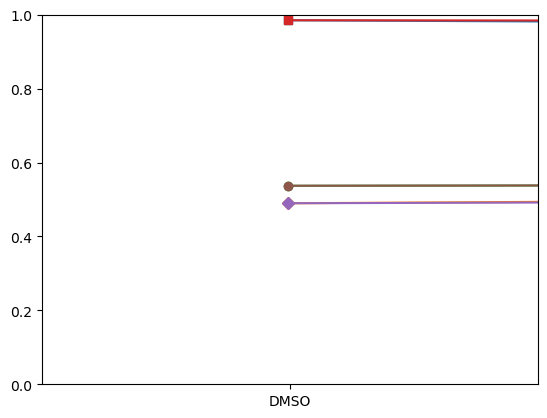

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.transforms as transforms


def lineplot_F(df, x, y,z):
    form = {"X":"-s","TP":"-D","FY":"-o"}
    for xl in df[x].unique():
        print(xl)
        if xl == "DMSO":
            continue
        for zl in df[z].unique():
            print(zl)
            X = ["DMSO",xl]
            Y = [df[y][df[x]=="DMSO"][df[z]==zl].median(),df[y][df[x]==xl][df[z]==zl].median()]
            plt.plot(X,Y,form[zl],scaley = False)
    plt.show()
    return

lineplot_F(df, "Group2", "Mean_norm_X","Group1")